In [1]:
%reset
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import *

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

# Custom Code Import
%autoreload 2
from fooof.fooof import *

def group_three(vec):
    """Takes array of inputs, groups by three."""
    
    return [list(vec[i:i+3]) for i in range(0, len(vec), 3)]

def rmse(preds, target):
    """Calculate root mean squared error."""
    
    return np.sqrt(((preds - target) ** 2).mean())

def abs_err_freq(preds, target):
    """Calculate the absolute error across frequencies."""
    
    return np.abs(preds - target)


from scipy import signal

def data_ecog2(chandat, srate, channel):
    # make the PSD
    window_size = int(srate*10)
    overlap = int(window_size * 0.5)

    xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
    psd_array = np.log10(psd_array)

    return psd_array,xf

import os
my_dir = '/Users/Voytek/fooof/data'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# %%timeit

# eeg
file = 'eeg/22.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 50]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# Fix up PSD
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

# # lfp
# file = 'lfp/i010_ch08_raw.npy'
# filename = os.path.join(my_dir, file)
# freq_range = [0, 50]
# psd_array = np.load(filename)
# psd_array = np.log10(psd_array)
# range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
# freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# # Fix up PSD
# psd_array = np.vstack((psd_array, psd_array))
# psd_array = psd_array.T

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [1, 44]
bw_limits = [0.5, 8]

bandwidth_limits = bw_limits
frequency_range = cut_freqs
frequency_vector = freqs
input_psd = psd_array

# outlier amplitude is also the minimum amplitude required for counting as an "oscillation"
# this is express as percent relative maximum oscillation height
threshold = 0.025

# set the parameter bounds for the gaussians
lo_bound = frequency_range[0], 0, bandwidth_limits[0]
hi_bound = frequency_range[1], np.inf, bandwidth_limits[1]

# default 1/f parameter bounds limit slope to be negative, and no steeper than -8
param_bounds = (-np.inf, -8, -np.inf), (np.inf, 0, 0)

# convert window_around_max to freq
window_around_max = np.int(np.ceil(window_around_max/(frequency_vector[1]-frequency_vector[0])))

# trim the PSD
frequency_vector, foof_spec = trim_psd(input_psd, frequency_vector, frequency_range)

# Check dimensions
if np.shape(frequency_vector)[0] == np.shape(foof_spec)[0]:
    foof_spec = foof_spec.T

# NOTE: Since all we do is average, what is the benefit of taking multiple PSDs?
#   - Since we only ever fit 1, could add a note to average before FOOOF, if user wants

# Average across all provided PSDs
trimmed_psd = np.nanmean(foof_spec, 0)

# fit the background 1/f
background_params, background_fit = clean_background_fit(frequency_vector, trimmed_psd,
                                                         threshold, param_bounds)
p_flat_real = trimmed_psd - background_fit
p_flat_real[p_flat_real < 0] = 0
p_flat_iteration = np.copy(p_flat_real)

guess = np.empty((0, 3))
gausi = 0
while gausi < number_of_gaussians:
    max_index = np.argmax(p_flat_iteration)
    max_amp = p_flat_iteration[max_index]

    # trim gaussians at the edges of the PSD
    # trimming these here dramatically speeds things up, since the trimming later...
    # ... requires doing the gaussian curve fitting, which is slooow
    cut_freq = [0, 0]
    cut_freq[0] = np.int(np.ceil(frequency_range[0]/(frequency_vector[1]-frequency_vector[0])))
    cut_freq[1] = np.int(np.ceil(frequency_range[1]/(frequency_vector[1]-frequency_vector[0])))
    drop_cond1 = (max_index - window_around_max) <= cut_freq[0]
    drop_cond2 = (max_index + window_around_max) >= cut_freq[1]
    drop_criterion = drop_cond1 | drop_cond2

    if ~drop_criterion:

        # set the guess parameters for gaussian fitting (bw = 2)
        guess_freq = frequency_vector[max_index]
        guess_amp = max_amp
        guess_bw = 2.
        guess = np.vstack((guess, (guess_freq, guess_amp, guess_bw)))

        # flatten the flat PSD around this peak
        flat_range = ((max_index-window_around_max), (max_index+window_around_max))
        p_flat_iteration[flat_range[0]:flat_range[1]] = 0

    # flatten edges if the "peak" is at the edge (but don't store that as a gaussian to fit)
    if drop_cond1:
        flat_range = (0, (max_index+window_around_max))
        p_flat_iteration[flat_range[0]:flat_range[1]] = 0

    if drop_cond2:
        flat_range = ((max_index-window_around_max), frequency_range[1])
        p_flat_iteration[flat_range[0]:flat_range[1]] = 0

    gausi += 1

if len(guess) > 0:

    # remove low amplitude gaussians
    amp_cut =  0.5 * np.var(p_flat_real)
    amp_params = [item[1] for item in guess]
    keep_osc = amp_params > amp_cut

    guess = [d for (d, remove) in zip(guess, keep_osc) if remove]
    num_of_oscillations = int(np.shape(guess)[0])
    guess = list(itertools.chain.from_iterable(guess))

    # make a list of the bounds to pass into the curve fitting
    gaus_param_bounds = lo_bound*num_of_oscillations, hi_bound*num_of_oscillations
    try:
        oscillation_params, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real,
                                          p0=guess, maxfev=5000, bounds=gaus_param_bounds)

    # TODO: should it do something in particular here?
    except:
        pass

    # iterate through gaussian fitting to remove implausible oscillations
    keep_osc = False
    while ~np.all(keep_osc):

        # remove gaussians by cf and bandwidth
        osc_params = group_three(oscillation_params)
        cf_params = [item[0] for item in osc_params]
        bw_params = [item[2] for item in osc_params]
        keep_osc = decision_criterion(cf_params, bw_params, frequency_range, bandwidth_limits)
        guess = [d for (d, remove) in zip(osc_params, keep_osc) if remove]

        # Remove oscillations due to BW overlap (one osc is entirely within another)
        guess = drop_overlapping_oscs(guess)

        if len(guess) > 0:
            num_of_oscillations = int(np.shape(guess)[0])
            guess = list(itertools.chain.from_iterable(guess))
            gaus_param_bounds = lo_bound*num_of_oscillations, hi_bound*num_of_oscillations
            oscillation_params, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real,
                                              p0=guess, maxfev=5000, bounds=gaus_param_bounds)

        # logic to handle background fit when there are no oscillations
        else:
            keep_osc = True
            oscillation_params = []

    if len(oscillation_params) > 0:
        gaussian_fit = gaussian_function(frequency_vector, *oscillation_params)
        psd_fit = gaussian_fit + background_fit
    else:
        log_f = np.log10(frequency_vector)
        psd_fit, _ = quick_background_fit(log_f, trimmed_psd, param_bounds)
        gaussian_fit = np.zeros_like(frequency_vector)
        oscillation_params = []

# logic handle background fit when there are no oscillations
else:
    log_f = np.log10(frequency_vector)
    psd_fit, _ = quick_background_fit(log_f, trimmed_psd, param_bounds)
    gaussian_fit = np.zeros_like(frequency_vector)
    oscillation_params = []











plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

DROPPED
CPU times: user 278 ms, sys: 2.17 ms, total: 280 ms
Wall time: 71 ms


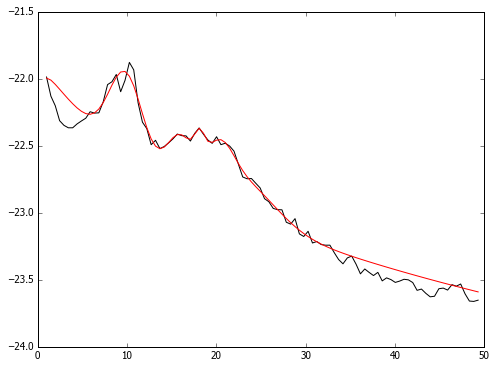

[ -2.19934469e+01  -6.24101274e-16  -5.57033403e-01]
[  9.86363082   0.59533066   2.62386081  15.90815231   0.32735911
   2.0962942   18.12477299   0.18002518   0.82394339  20.34560419
   0.26926382   2.17051789  22.83462339   0.27706549   5.29531441]


In [7]:
# OR: load MEG data from npy file

dat = np.load('meg_dat.npy')

freqs = dat[0]
psd = dat[1]

# Set which PSD to run
cur_psd = psd[1021, :]

# Fix up PSD
psd_array = np.log10(cur_psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [1, 50]
bw_limits = [0.5, 8]

# Run FOOOF
%time p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

In [ ]:
# LFP

import os

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [1, 44]
bw_limits = [0.5, 8]

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data/lfp'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # lfp
        filename = os.path.join(my_dir, file)
        freq_range = [0, 49]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T

        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)
        
        if np.any(oscillation_params):
            oscillation_params = group_three(oscillation_params)

            for i in range(np.shape(oscillation_params)[0]):
                col_cf.append(oscillation_params[i][0])
                col_bw.append(oscillation_params[i][2])
                col_file.append(file)
        else:
            col_cf.append(0)
            col_bw.append(0)
            col_file.append(file)     

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('lfp.csv', sep=',', index = False)

In [ ]:
# EEG

import os

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 4
cut_freqs = [1, 40]
bw_limits = [0.5, 8]

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data/eeg'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # eeg
        filename = os.path.join(my_dir, file)
        freq_range = [0, 50]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T
        
        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)
        
        if np.any(oscillation_params):
            oscillation_params = group_three(oscillation_params)

            for i in range(np.shape(oscillation_params)[0]):
                col_cf.append(oscillation_params[i][0])
                col_bw.append(oscillation_params[i][2])
                col_file.append(file)
        else:
            col_cf.append(0)
            col_bw.append(0)
            col_file.append(file)

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('eeg.csv', sep=',', index = False)

In [ ]:
from scipy import stats

eeg = pd.read_csv('fits/eeg.csv', sep=',')
# plt.scatter(eeg[['cf']], eeg[['bw']], color='b')

lfp = pd.read_csv('fits/lfp.csv', sep=',')
# plt.scatter(lfp[['cf']], lfp[['bw']], color='g')
# plt.show()

frames = [lfp]

df = pd.concat(frames)

df = df[df['bw'] < 8]
df = df[df['bw'] > 0.5]
df = df[df['cf'] < 50]

plt.scatter(df[['cf']], df[['bw']])
plt.show()

r,p = stats.pearsonr(df[['cf']], df[['bw']])
r,p

In [ ]:
# real eeg

import os
from fooof.dat import data_ecog
import pandas as pd


col_cf = []
col_bw = []
col_amp = []
col_offset = []
col_slope = []
col_curve = []
col_chan = []
col_file = []

srate = 256.
# FOOOF SETTINGS
window_around_max = 4
number_of_gaussians = 6
cut_freqs = [2, 30]
bw_limits = [0.5, 8]

my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.csv'):
        filename = os.path.join(my_dir, file)

        chandat = np.loadtxt(filename, delimiter=",")
        if np.shape(chandat)[0]<np.shape(chandat)[1]:
            chandat = chandat.T
        
        channels = np.shape(chandat)[1]
        
        for ci in range(channels):
            tempdat = chandat[:, ci]
            psd_array, freqs = data_ecog2(tempdat, srate, ci)


            # Run FOOOF
            p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
                fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

            if np.any(oscillation_params):
                oscillation_params = group_three(oscillation_params)

                for i in range(np.shape(oscillation_params)[0]):
                    col_cf.append(oscillation_params[i][0])
                    col_amp.append(oscillation_params[i][1])
                    col_bw.append(oscillation_params[i][2])
                    col_offset.append(background_params[0])
                    col_slope.append(background_params[2])
                    col_curve.append(background_params[1])
                    col_chan.append(ci)
                    col_file.append(file)
            else:
                col_cf.append(0)
                col_amp.append(0)
                col_bw.append(0)
                col_offset.append(background_params[0])
                col_slope.append(background_params[2])
                col_curve.append(background_params[1])
                col_chan.append(ci)
                col_file.append(file)


d = {'file': col_file, 'cf': col_cf, 'bw': col_bw, 'amp': col_amp, 'offset': col_offset, 'slope': col_slope, 'curve': col_curve, 'chan': col_chan}
df = pd.DataFrame(data=d)
df = df[['file', 'chan', 'cf', 'bw', 'amp', 'offset', 'slope', 'curve']]
df.to_csv('real_eeg.csv', sep=',', index = False)


In [ ]:
# real eeg

import os
from fooof.dat import data_ecog
import pandas as pd


col_cf = []
col_bw = []
col_amp = []
col_offset = []
col_slope = []
col_curve = []
col_chan = []
col_file = []

srate = 256.
# FOOOF SETTINGS
window_around_max = 4
number_of_gaussians = 6
cut_freqs = [2, 30]
bw_limits = [0.5, 10]

filename = os.path.join('/Users/Voytek/fooof/data/6.csv')

chandat = np.loadtxt(filename, delimiter=",")
if np.shape(chandat)[0]<np.shape(chandat)[1]:
    chandat = chandat.T

channels = np.shape(chandat)[1]

ci=46

tempdat = chandat[:, ci]
psd_array, freqs = data_ecog2(tempdat, srate, ci)


# Run FOOOF
%timeit p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

In [ ]:
from scipy import stats
import pandas as pd

df = pd.read_csv('real_eeg.csv', sep=',')


df = df[df['bw'] < 5]
df = df[df['bw'] > 0.5]
df = df[df['cf'] < 35]
df = df[df['slope'] > -5]
df = df[df['slope'] < 0]

plt.scatter(df[['cf']], df[['bw']])
plt.show()

r,p = stats.pearsonr(df[['cf']], df[['bw']])
r,p